In [63]:
%load_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [64]:
from utils import read_file
import pandas as pd
import datetime

# basic configurations
FILE = "data/Events-Match_Test__TEAM_A_vs__TEAM_B-Period_Period_1_Period_Period_2_Period_Period_3.csv"
EVENT_TYPE = "Shifts"

# load initial dataset
df = read_file(FILE, EVENT_TYPE)
df

,Timestamp (ms),Timestamp in local format,Player ID,Name,Event type,Duration (s),Distance,Distance (speed | Very low),Distance (speed | Low),Distance (speed | Medium),Distance (speed | High),Distance (speed | Very high),Distance (speed | Sprint),Distance (speed | 0 - 0 km/h),Metabolic Power (Ø),Speed (max.),Skating Load,Skating Intensity
0,1670697995000,12/10/2022;07:46:35.000 PM,438,D TEST,Shift,34.707001,114.0,29.0,15,25,36,9,0.0,NaN,337.08,22.60,21.67,37.45
1,1670697995000,12/10/2022;07:46:35.000 PM,443,D TEST,Shift,43.952999,177.0,25.0,21,39,51,36,4.0,NaN,413.47,24.34,28.74,39.24
4,1670697995000,12/10/2022;07:46:35.000 PM,470,D3 Guest,Shift,82.765999,288.0,45.0,83,70,87,3,0.0,NaN,0.00,21.88,51.74,37.51
7,1670697995000,12/10/2022;07:46:35.000 PM,471,D4 Guest,Shift,57.615002,215.0,34.0,29,59,79,14,0.0,NaN,0.00,21.75,46.27,48.18
11,1670697995000,12/10/2022;07:46:35.000 PM,448,FW TEST,Shift,20.010000,1.0,1.0,0,0,0,0,0.0,NaN,9.93,4.64,0.49,1.47
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13052,1670705504000,12/10/2022;09:51:44.000 PM,455,FW TEST,Shift,14.317000,30.0,12.0,8,0,3,7,0.0,NaN,356.84,21.82,0.84,3.50
13085,1670705547000,12/10/2022;09:52:27.000 PM,441,D TEST,Shift,3.623000,1.0,1.0,0,0,0,0,0.0,NaN,62.98,4.88,1.34,22.15
13086,1670705547000,12/10/2022;09:52:27.000 PM,450,FW TEST,Shift,3.623000,5.0,5.0,0,0,0,0,0.0,NaN,150.85,8.24,2.60,43.10
13087,1670705547000,12/10/2022;09:52:27.000 PM,453,FW TEST,Shift,3.588000,3.0,3.0,0,0,0,0,0.0,NaN,136.72,9.65,2.40,40.19


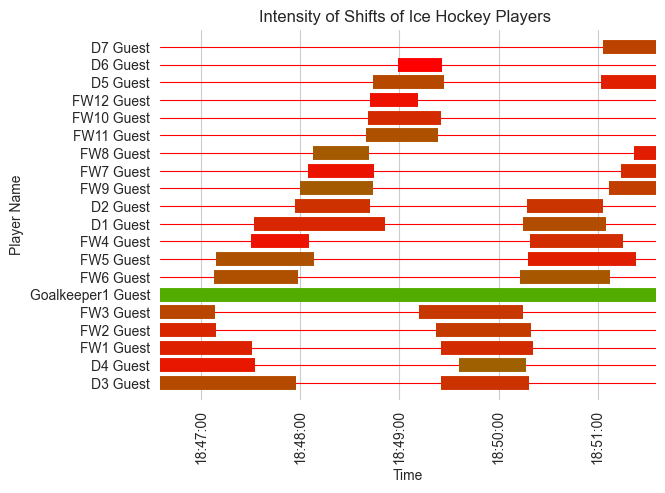

In [65]:
import random
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

random.seed(42)

def get_colour(intensity: int) -> str:
    """
    creates a colour between green and red  according to intensity

    :param intensity: hockey intensity within [0,1]
    :return: linear interpolation between green = easy and red = heavy in hex-format, e.g. #FF0000
    """

    # LERP between green and red
    green = int((1-intensity) * 255)
    red = int(intensity * 255)

    colour = "#%02x%02x%02x" % (red, green, 0) # blue value is 0
    return colour


def plot_shifts_with_intensity(df: pd.DataFrame, time_window: int):
    """
    Plots shifts of all players together with the intensity of all individual shifts

    ONLY WORKS FOR GUEST DATA FOR NOW.

    :param df: dataframe with shift data
    :param time_window:  how much time should be plotted? (in minutes)
    :return: None
    """

    # prepare dataframe
    df["timestamp"] = pd.to_datetime(df["Timestamp (ms)"], unit="ms")
    df["time"] = pd.to_timedelta(df["Duration (s)"], unit="sec")
    df = df[df["timestamp"] < df["timestamp"].min() + datetime.timedelta(minutes=time_window)]
    df = df[df["Name"].str.contains("Guest")]

    # create plot
    fig,ax = plt.subplots()

    # plot bars
    for i in df.index:
        relative_intensity = float(df["Skating Intensity"][i] / df["Skating Intensity"].max())
        ax.plot([df['timestamp'][i],df['timestamp'][i] + df['time'][i]],
                [df['Name'][i],df['Name'][i]],
                linewidth=10,
                c=get_colour(relative_intensity), #cols[df['Player ID'][i]],
                solid_capstyle = "butt")

    # format date on x axis
    myFmt = mdates.DateFormatter('%H:%M:%S')
    ax.xaxis.set_major_formatter(myFmt)
    plt.xticks(rotation=90)
    plt.xlim(df["timestamp"].min(), df["timestamp"].min() + datetime.timedelta(minutes=time_window))

    # some configurations for background
    ax.grid(axis="y", color="r")
    ax.set(frame_on=False)

    # label axes
    plt.xlabel("Time")
    plt.ylabel("Player Name")
    plt.title("Intensity of Shifts of Ice Hockey Players ")

    # display plit
    plt.show()

plot_shifts_with_intensity(df, 5)

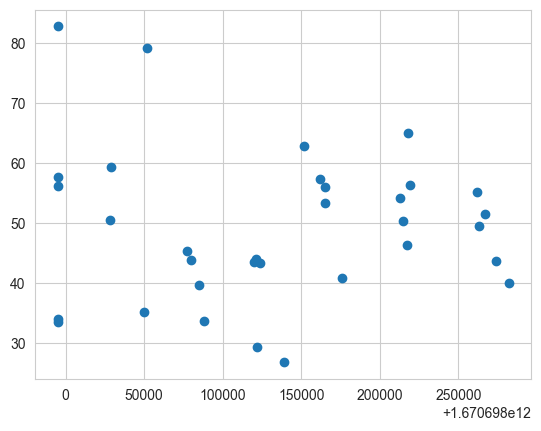

In [66]:
df_no_keepers = df[~df["Name"].str.contains("Goalkeeper")]
df_no_keepers = df_no_keepers[df_no_keepers["timestamp"] < df_no_keepers["timestamp"].min() + datetime.timedelta(minutes=5)]
df_no_keepers = df_no_keepers[df_no_keepers["Name"].str.contains("Guest")]

plt.scatter(df_no_keepers["Timestamp (ms)"], df_no_keepers["Duration (s)"])
plt.show()

Estimated number of shifts =  7


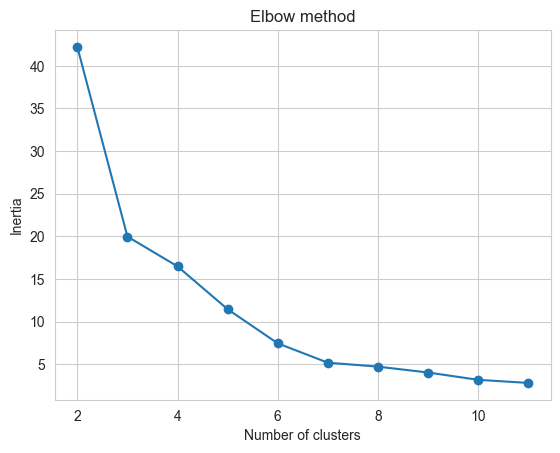

Knee, i.e. calculated number of shifts: 5


In [67]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from kneed import KneeLocator

nof_players_per_shift = 5
nof_shifts = int(df_no_keepers.shape[0] / nof_players_per_shift) + 1

print("Estimated number of shifts = ", nof_shifts)


data = list(zip(df_no_keepers["Timestamp (ms)"], df_no_keepers["Duration (s)"]))
scaler = StandardScaler()
scaled_data = scaler.fit_transform(data)

inertias = []

for i in range(nof_shifts - 5, nof_shifts + 5):
    kmeans = KMeans(n_clusters=i)
    kmeans.fit(scaled_data)
    inertias.append(kmeans.inertia_)


plt.plot(range(nof_shifts - 5, nof_shifts + 5), inertias, marker='o')
plt.title('Elbow method')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.show()

k1 = KneeLocator(range(nof_shifts - 5, nof_shifts + 5), inertias, curve="convex", direction="decreasing")
print("Knee, i.e. calculated number of shifts:", k1.knee)

len of rows = 33
len of labels = 33


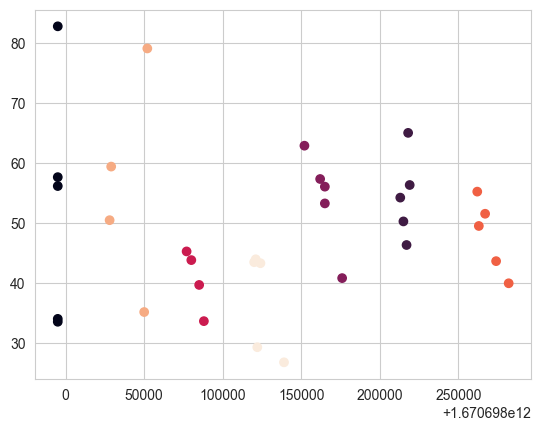

,Timestamp (ms),Timestamp in local format,Player ID,Name,Event type,Duration (s),Distance,Distance (speed | Very low),Distance (speed | Low),Distance (speed | Medium),...,Distance (speed | Very high),Distance (speed | Sprint),Distance (speed | 0 - 0 km/h),Metabolic Power (Ø),Speed (max.),Skating Load,Skating Intensity,timestamp,time,Shift_Label
4,1670697995000,12/10/2022;07:46:35.000 PM,470,D3 Guest,Shift,82.765999,288.0,45.0,83,70,...,3,0.0,NaN,0.00,21.88,51.74,37.51,2022-12-10 18:46:35,0 days 00:01:22.765999,0
7,1670697995000,12/10/2022;07:46:35.000 PM,471,D4 Guest,Shift,57.615002,215.0,34.0,29,59,...,14,0.0,NaN,0.00,21.75,46.27,48.18,2022-12-10 18:46:35,0 days 00:00:57.615002,0
18,1670697995000,12/10/2022;07:46:35.000 PM,478,FW1 Guest,Shift,56.131001,254.0,24.0,34,19,...,39,101.0,NaN,0.00,27.57,43.10,46.07,2022-12-10 18:46:35,0 days 00:00:56.131001,0
19,1670697995000,12/10/2022;07:46:35.000 PM,479,FW2 Guest,Shift,33.981998,109.0,26.0,10,21,...,7,15.0,NaN,0.00,26.79,25.60,45.19,2022-12-10 18:46:35,0 days 00:00:33.981998,0
21,1670697995000,12/10/2022;07:46:35.000 PM,480,FW3 Guest,Shift,33.499001,142.0,10.0,8,35,...,40,28.0,NaN,0.00,28.38,21.48,38.47,2022-12-10 18:46:35,0 days 00:00:33.499001,0
155,1670698028000,12/10/2022;07:47:08.000 PM,483,FW6 Guest,Shift,50.438999,198.0,24.0,18,42,...,62,5.0,NaN,0.00,24.72,30.63,36.44,2022-12-10 18:47:08,0 days 00:00:50.438999,5
159,1670698029000,12/10/2022;07:47:09.000 PM,482,FW5 Guest,Shift,59.375000,235.0,21.0,43,51,...,5,17.0,NaN,0.00,28.88,35.83,36.21,2022-12-10 18:47:09,0 days 00:00:59.375000,5
242,1670698050000,12/10/2022;07:47:30.000 PM,481,FW4 Guest,Shift,35.120998,149.0,17.0,6,5,...,35,59.0,NaN,0.00,30.91,28.94,49.45,2022-12-10 18:47:30,0 days 00:00:35.120998,5
250,1670698052000,12/10/2022;07:47:32.000 PM,468,D1 Guest,Shift,79.073997,272.0,52.0,38,43,...,26,24.0,NaN,0.00,27.67,59.44,45.10,2022-12-10 18:47:32,0 days 00:01:19.073997,5
370,1670698077000,12/10/2022;07:47:57.000 PM,469,D2 Guest,Shift,45.229000,175.0,28.0,13,27,...,28,26.0,NaN,0.00,27.31,32.21,42.73,2022-12-10 18:47:57,0 days 00:00:45.229000,3


In [68]:
# According to plot above, we probably have 12 shifts, i.e. 12 clusters
kmeans = KMeans(n_clusters=7)
kmeans.fit(data)

print("len of rows =", df_no_keepers.shape[0])
print("len of labels =", len(kmeans.labels_))

df_no_keepers["Shift_Label"] = kmeans.labels_

plt.scatter(df_no_keepers["Timestamp (ms)"], df_no_keepers["Duration (s)"], c=kmeans.labels_)
plt.show()

df_no_keepers

In [69]:
df_shift_intensities = df_no_keepers.groupby("Shift_Label")["Skating Intensity"].mean().reset_index().set_index("Shift_Label")
# df_shift_intensities = df_shift_intensities.set_index("Shift_Label")
df_shift_intensities

,Skating Intensity
Shift_Label,
0,43.0840
1,40.9640
2,40.4000
3,40.1225
4,43.5040
5,41.8000
6,44.2620


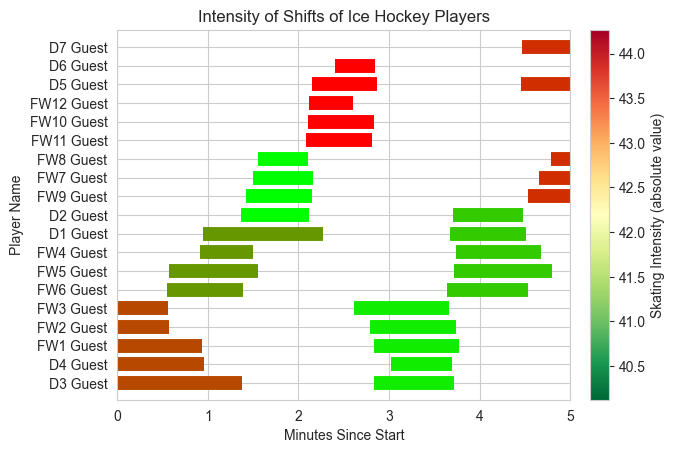

In [70]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.cm as cm
import numpy as np
import datetime

def get_colour(intensity: float, min_intensity: float, max_intensity: float) -> str:
    """
    Creates a colour between green and red according to intensity, where green is less intense and red is more intense.

    :param intensity: The absolute intensity value.
    :param min_intensity: The minimum intensity value for normalization.
    :param max_intensity: The maximum intensity value for normalization.
    :return: A hex color string, linearly interpolated between green (less intense) and red (more intense).
    """
    # Normalize the intensity value between 0 and 1
    normalized_intensity = (intensity - min_intensity) / (max_intensity - min_intensity)
    green = int((1 - normalized_intensity) * 255)
    red = int(normalized_intensity * 255)
    return f"#{red:02x}{green:02x}00"  # blue value is 0

def plot_shifts_with_intensity(df: pd.DataFrame, df_avg_intensities: pd.DataFrame, time_window: int):
    """
    Plots shifts of all players together with the intensity of all individual shifts,
    including a color bar to represent the intensity scale from less intense (green) to more intense (red).

    ONLY WORKS FOR GUEST DATA FOR NOW.

    :param df: DataFrame with shift data.
    :param df_avg_intensities: DataFrame with average intensities for each shift.
    :param time_window: How much time should be plotted? (in minutes)
    :return: None
    """
    # Calculate the time difference from the start
    df['timestamp'] = pd.to_datetime(df['timestamp'])
    start_time = df['timestamp'].min()
    df['Time Since Start'] = (df['timestamp'] - start_time).dt.total_seconds() / 60  # Convert to minutes

    # Determine the range of intensities
    min_intensity = df_avg_intensities["Skating Intensity"].min()
    max_intensity = df_avg_intensities["Skating Intensity"].max()

    # Create plot
    fig, ax = plt.subplots()

    # Plot shifts
    for i in df.index:
        absolute_intensity = df_avg_intensities["Skating Intensity"][df["Shift_Label"][i]]
        color = get_colour(absolute_intensity, min_intensity, max_intensity)
        start_minute = df['Time Since Start'][i]
        end_minute = start_minute + df['time'][i].total_seconds() / 60

        ax.plot([start_minute, end_minute],
                [df['Name'][i], df['Name'][i]],
                linewidth=10,
                color=color,
                solid_capstyle="butt")

    # Set x-axis format
    plt.xlabel("Minutes Since Start")
    plt.ylabel("Player Name")
    plt.title("Intensity of Shifts of Ice Hockey Players")
    plt.xlim(0, time_window)

    # Create a custom color bar
    norm = mcolors.Normalize(vmin=min_intensity, vmax=max_intensity)
    sm = cm.ScalarMappable(norm=norm, cmap=cm.RdYlGn_r)  # Notice the _r for reverse colormap
    sm.set_array([])
    cbar = plt.colorbar(sm, ax=ax, orientation='vertical', fraction=0.046, pad=0.04)
    cbar.set_label('Skating Intensity (absolute value)') # tbc, we will define a formula for this with relative values later for the hole game or a period (here it would be 5 minutes)

    # Display plot
    plt.show()

# Example call to the function (assuming df_no_keepers and df_shift_intensities are defined)
plot_shifts_with_intensity(df_no_keepers, df_shift_intensities, 5)

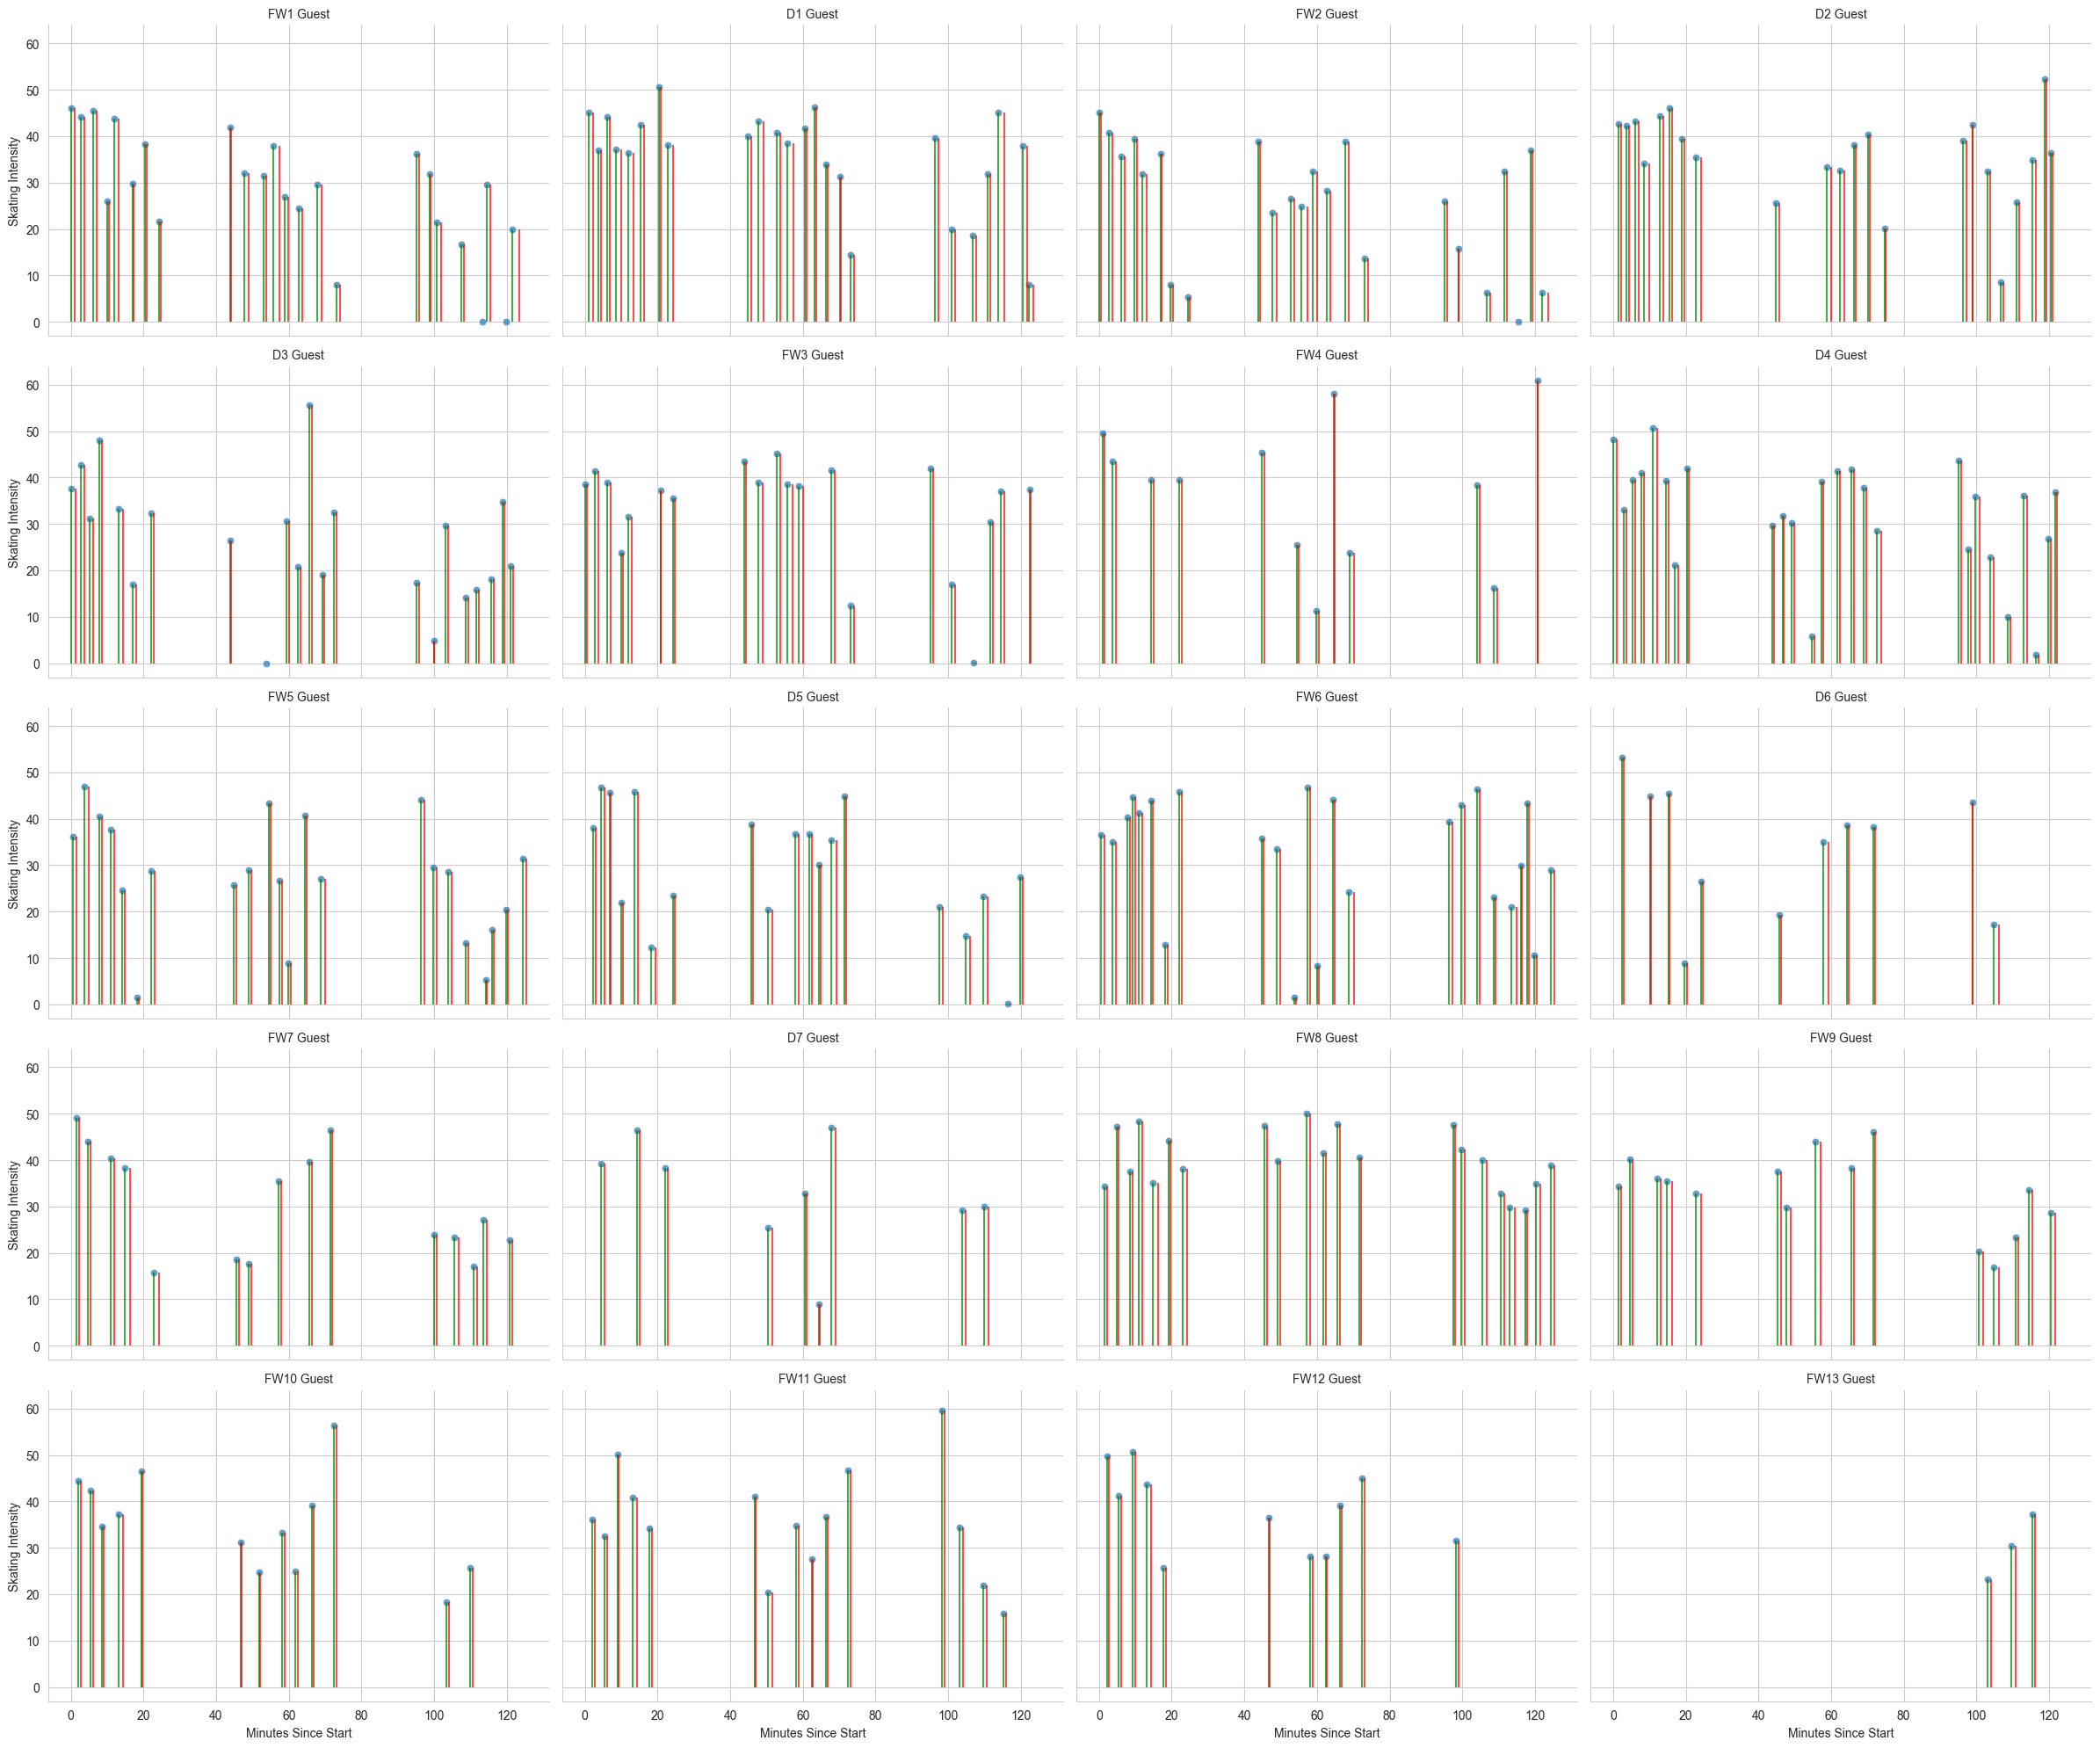

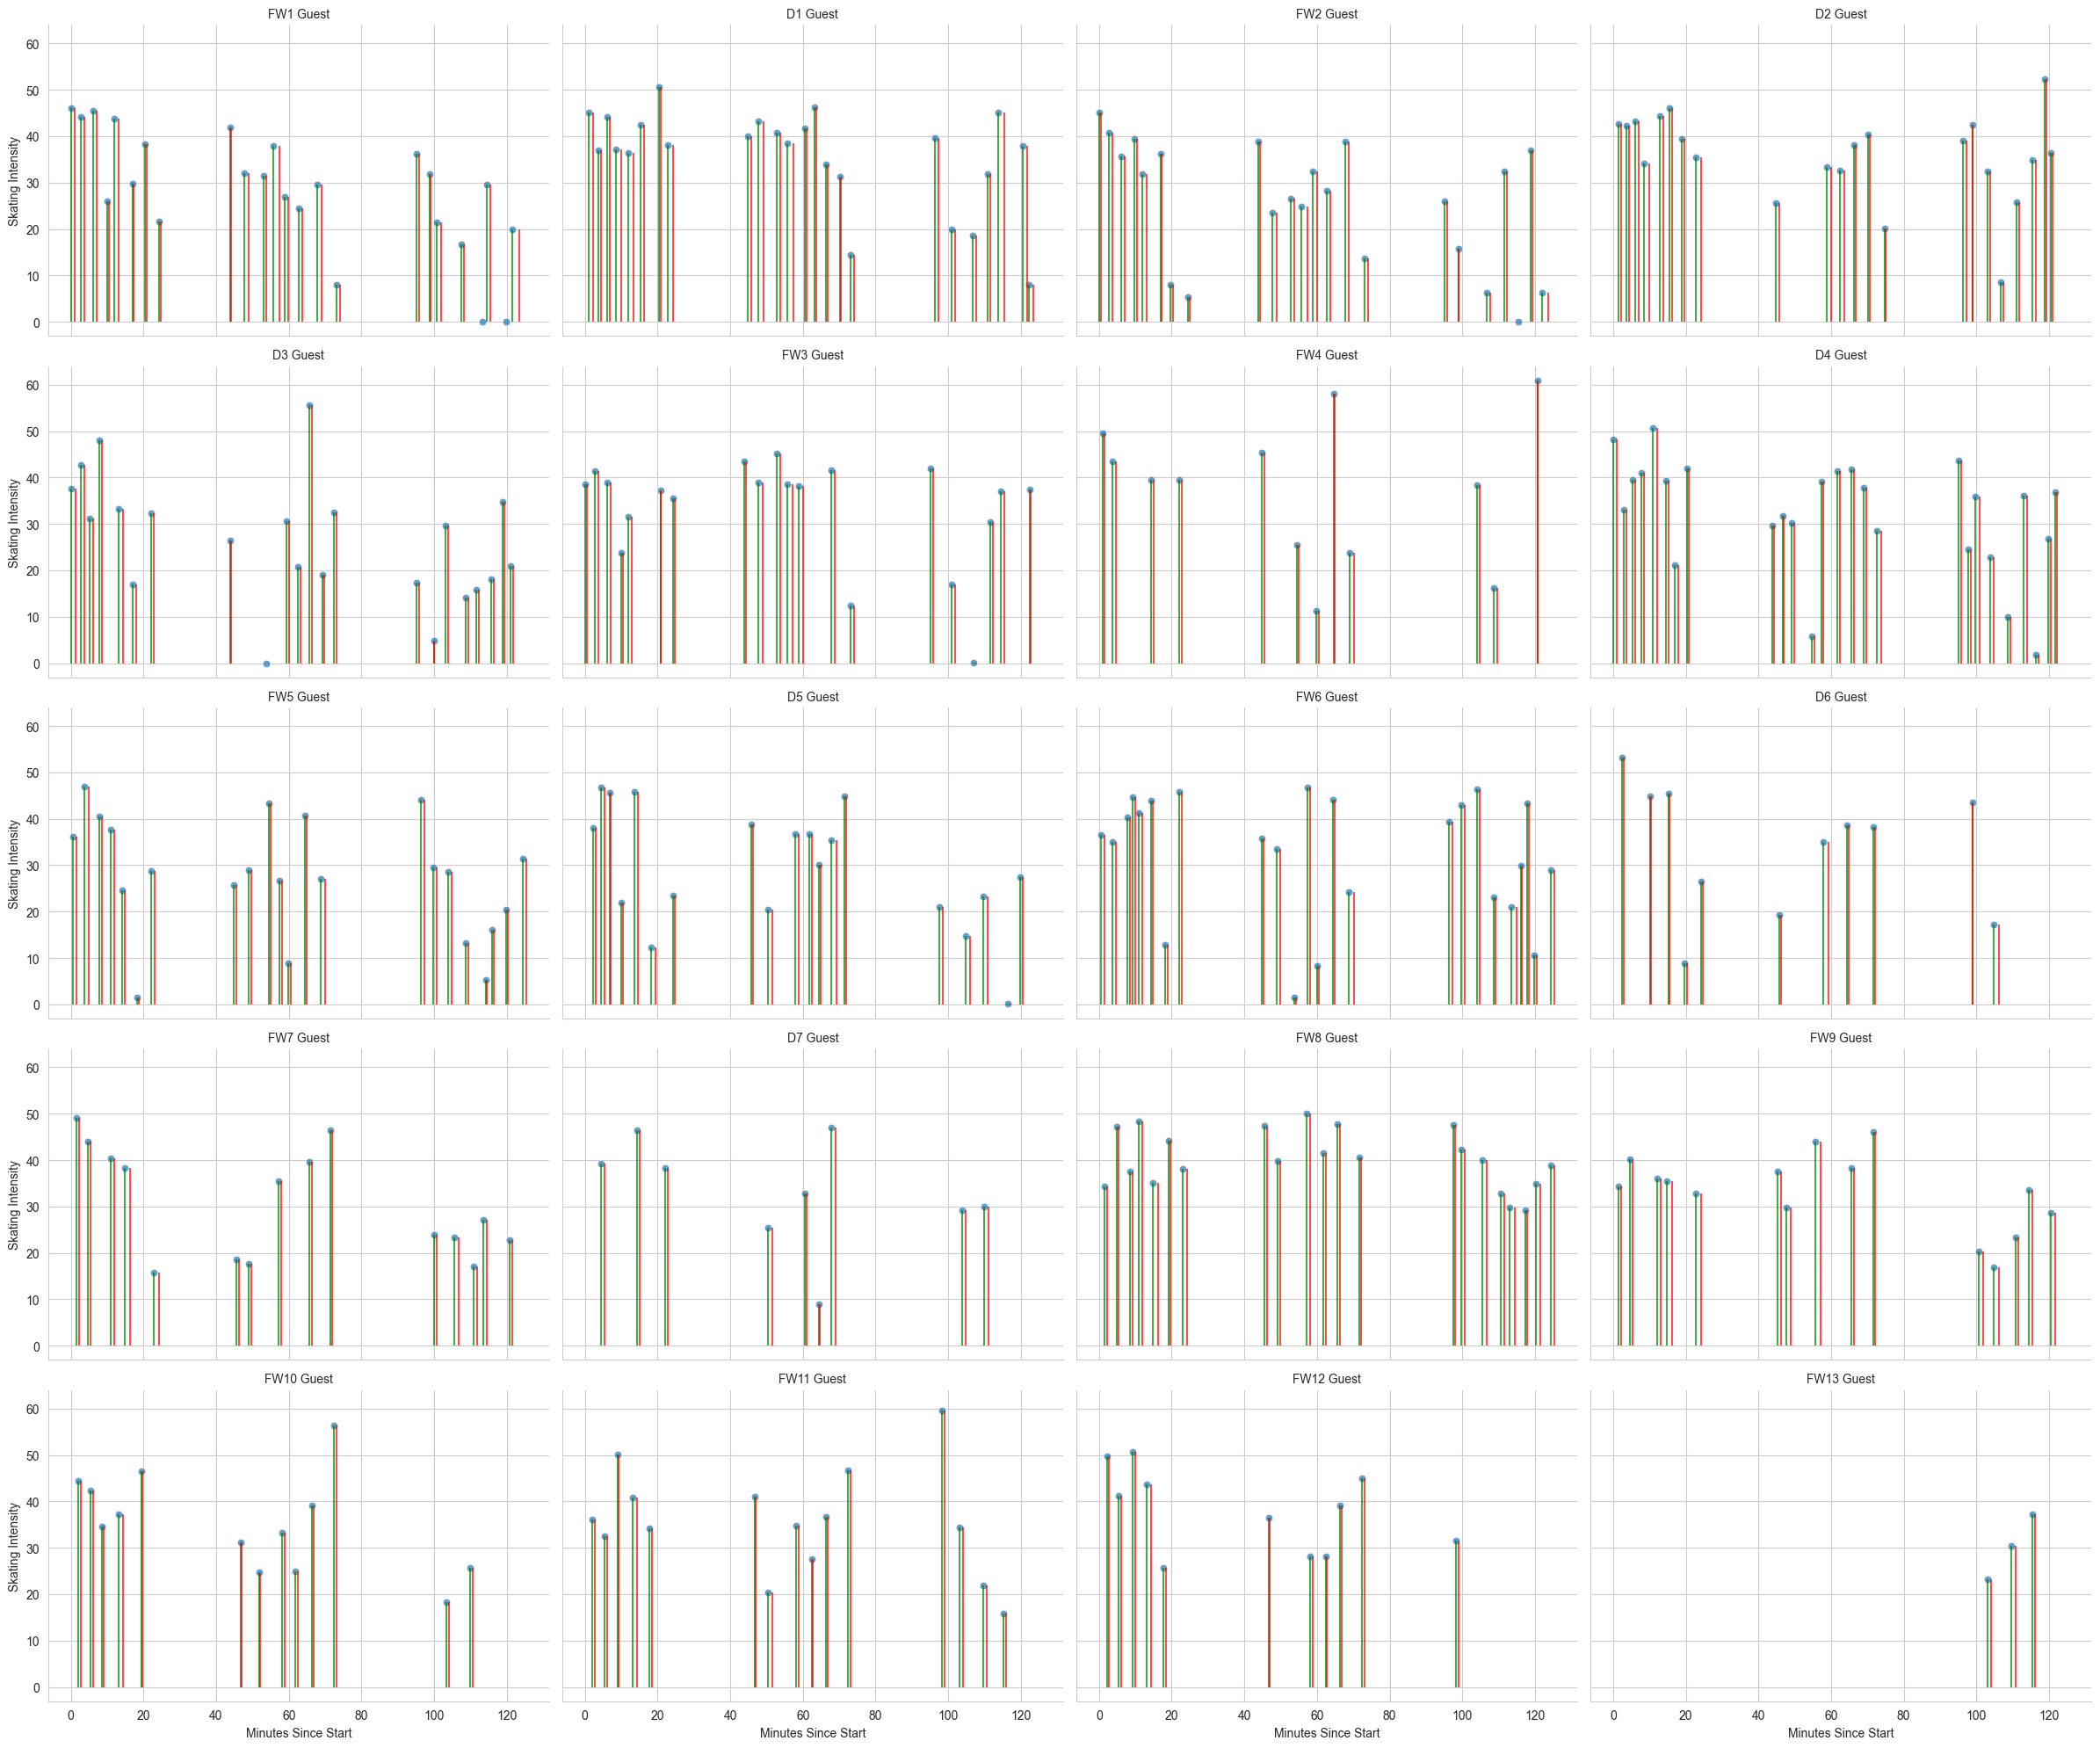

In [73]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime

def plot_skating_intensity(df: pd.DataFrame, time_window: int):
    """
    Plots skating intensity over time for "Guest" players excluding goalkeepers.

    :param df: DataFrame with player data including 'Timestamp (ms)', 'Name', and 'Skating Intensity'.
    :param time_window: How much time should be plotted, in minutes, from the start.
    """
    # Convert timestamps to readable format and calculate duration since start
    df['Readable Timestamp'] = pd.to_datetime(df['Timestamp (ms)'], unit='ms')
    df['End Timestamp'] = df['Readable Timestamp'] + pd.to_timedelta(df['Duration (s)'], unit='s')
    df['Duration Since Start'] = (df['Readable Timestamp'] - df['Readable Timestamp'].min()).dt.total_seconds() / 60  # Convert to minutes

    # Filter to include only "Guest" players and exclude goalkeepers
    df_filtered = df[df["Name"].str.contains("Guest") & ~df["Name"].str.contains("Goalkeeper")].copy()

    # Extracting numeric part from names for sorting
    df_filtered['Name Number'] = df_filtered['Name'].str.extract('(\d+)').astype(int)

    # Sorting by extracted numbers
    df_filtered = df_filtered.sort_values('Name Number')

    # Creating the visualization
    g = sns.FacetGrid(df_filtered, col="Name", col_wrap=4, height=4, aspect=1.5)

    def draw_duration_lines(data, **kwargs):
        ax = plt.gca()
        for _, row in data.iterrows():
            start_time = row['Duration Since Start']
            duration = (row['End Timestamp'] - row['Readable Timestamp']).total_seconds() / 60  # Conversion to minutes
            end_time = start_time + duration
            # Draw lines indicating the duration of each event (start = green, end = red)
            ax.vlines(x=start_time, ymin=0, ymax=row['Skating Intensity'], color='green', linestyle='-', alpha=0.7)
            ax.vlines(x=end_time, ymin=0, ymax=row['Skating Intensity'], color='red', linestyle='-', alpha=0.7)

    g.map_dataframe(draw_duration_lines)
    g.map_dataframe(sns.scatterplot, 'Duration Since Start', 'Skating Intensity', alpha=0.7)
    g.set_axis_labels('Minutes Since Start', 'Skating Intensity')
    g.set_titles("{col_name}")

    plt.show()

plot_skating_intensity(df, 5)